In [67]:
import pandas as pd
from zipfile import ZipFile
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import geopandas as gpd
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

In [31]:
# Carregar o dataset
with ZipFile('consumidor_reclamacoes/consumidor_reclamacoes.zip', 'r') as arquivo:
    reclamacoes = pd.read_csv(arquivo.open("reclamacoes.csv"), encoding='utf-8', on_bad_lines='skip', delimiter=';')
    # contexto = pd.read_csv(arquivo.open("reclamacoes_contexto.csv"), encoding='utf-8', on_bad_lines='skip', delimiter=';')

In [32]:
# Preparar novamente o dataset
for col in reclamacoes.columns:
    if reclamacoes.dtypes[col] == object:
        reclamacoes[col] = pd.Categorical(reclamacoes[col])

reclamacoes.drop("Ano", axis=1, inplace=True)
reclamacoes.drop("Mês", axis=1, inplace=True)
reclamacoes["DataExtracao"] = pd.to_datetime(reclamacoes["DataExtracao"])
reclamacoes["AnoMês"] = pd.to_datetime(reclamacoes["AnoMês"].astype(str))

In [33]:
# Visualizar o dataset
reclamacoes

,DataExtracao,SOLICITAÇÕES,AnoMês,UF,Cidade,CO_MUNICIPIO,CanalEntrada,Condição,TipoAtendimento,Serviço,Marca,Assunto,Problema
0,2018-04-23,1,2015-01-01,DF,Brasília,5300108,SIC,Reencaminhada,Pedido de Informação,Outros,Outros,NÃO APLICÁVEL,SIC
1,2018-04-23,1,2015-01-01,AC,Rio Branco,1200401,Fale Conosco,Nova,Reclamação,STFC,OI,Bloqueio ou Suspensão e Desbloqueio,Bloqueio ou suspensão indevido
2,2018-04-23,1,2015-01-01,AL,Maceió,2704302,Fale Conosco,Nova,Reclamação,SMP_Pós,VIVO,Qualidade e Funcionamento do Serviço ou Equipa...,Lentidão ou velocidade reduzida de conexão
3,2018-04-23,1,2015-01-01,AM,Manaus,1302603,Fale Conosco,Reencaminhada,Reclamação,SMP_Pré,VIVO,Crédito Pré-pago,Crédito pré-pago cobrado de maneira indevida
4,2018-04-23,1,2015-01-01,AM,Manaus,1302603,Fale Conosco,Nova,Reclamação,STFC,OI,Qualidade e Funcionamento do Serviço ou Equipa...,Interrupção do serviço
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15952402,2020-06-16,1,2020-01-01,TO,Palmas,1721000,Call Center,Nova,Reclamação,SMP_Pós,OI,"Qualidade, Funcionamento e Reparo",Linha muda ou sem sinal
15952403,2020-06-16,1,2020-01-01,TO,Palmas,1721000,Usuário WEB,Nova,Reclamação,SeAC,CLARO,Cobrança,Cobrança em desacordo com o contratado
15952404,2020-06-16,1,2020-01-01,TO,Paraíso do Tocantins,1716109,Call Center,Nova,Reclamação,STFC,OI,Cobrança,Cobrança em desacordo com o contratado
15952405,2020-06-16,1,2020-01-01,TO,Porto Nacional,1718204,Call Center,Nova,Reclamação,SMP_Pós,OI,Dados cadastrais ou número da linha,Alteração do número de linha não solicitada


In [34]:
# Etapa 3: aprofundar a análise para extrair conhecimento relevante sobre as reclamações da Anatel, estabelecendo uma narrativa para storytelling

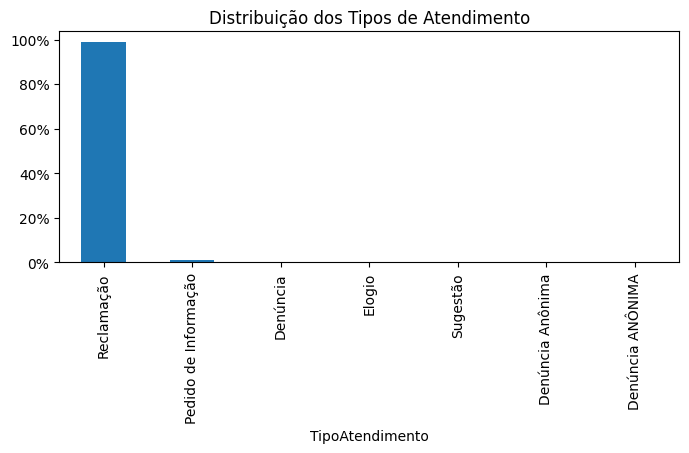

In [35]:
# Vamos simplificar os dados trabalhados para facilitar a extração de informações relevantes. Primeiramente, vamos ver a distribuição de TipoAtendimento:
counts = reclamacoes["TipoAtendimento"].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 3))
counts.plot.bar()
plt.ylabel("")
plt.title("Distribuição dos Tipos de Atendimento")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=100))
plt.show()


In [36]:
# O gráfico confirma que praticamente todos os atendimentos feitos à Anatel foram reclamações, o que foi assumido anteriormente na Análise Exploratória. Mas para uma análise mais rigorosa, vamos remover todas as linhas com os outros tipos (a maioria com dados insuficientes para análise) e remover a coluna TipoAtendimento
reclamacoes = reclamacoes[reclamacoes["TipoAtendimento"] == "Reclamação"].copy()
reclamacoes.drop("TipoAtendimento", axis=1, inplace=True)


In [37]:
# A data em que foi registrada a reclamação nao tem importância na análise:
reclamacoes.drop("DataExtracao", axis=1, inplace=True)

In [38]:
# O código do município é um detalhe refinado demais para a análise:
reclamacoes.drop("CO_MUNICIPIO", axis=1, inplace=True)

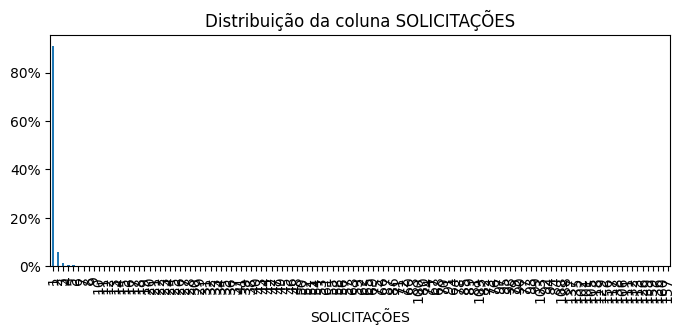

In [39]:
# Vamos ver a distribuição de SOLICITAÇÕES
counts = reclamacoes["SOLICITAÇÕES"].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 3))
counts.plot.bar()
plt.ylabel("")
plt.title("Distribuição da coluna SOLICITAÇÕES")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=100))
plt.show()

In [40]:
# A maioria dos consumidores fez apenas uma solicitação, com raras exceções em que foram feitas mais ligações para a Anatel. De qualquer forma, não acreditamos que conhecimento útil pode ser extraído desses dados
reclamacoes.drop("SOLICITAÇÕES", axis=1, inplace=True)

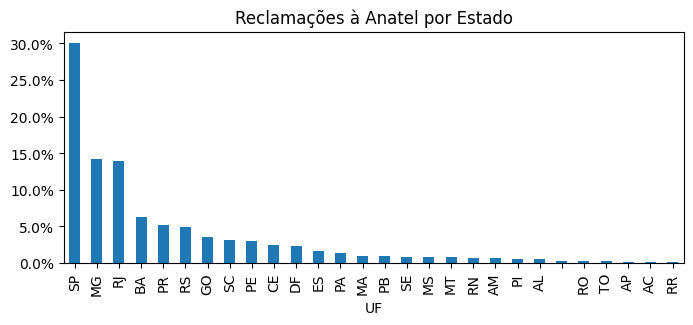

In [41]:
# Vamos ver a distribuição dos Estados:
counts = reclamacoes["UF"].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 3))
counts.plot.bar()
plt.ylabel("")
plt.title("Reclamações à Anatel por Estado")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=100))
plt.show()


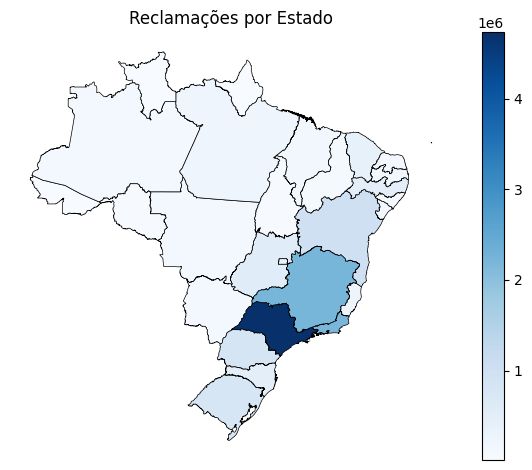

In [42]:
# Como visto no gráfico, o número de reclamações é proporcional à população do Estado, como esperado. Vamos confirmar com um mapa geográfico:
estados_gdf = gpd.read_file("https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson")
estados_gdf = estados_gdf.rename(columns={"sigla": "UF"})
estados_counts = reclamacoes["UF"].value_counts().rename_axis("UF").reset_index(name="count")
estados_gdf = estados_gdf.merge(estados_counts, on="UF", how="left")
estados_gdf["count"] = estados_gdf["count"].fillna(0)
ax = estados_gdf.plot(column="count", cmap="Blues", legend=True, edgecolor="black", linewidth=0.5)
ax.set_title("Reclamações por Estado")
ax.axis("off")
plt.tight_layout()
plt.show()


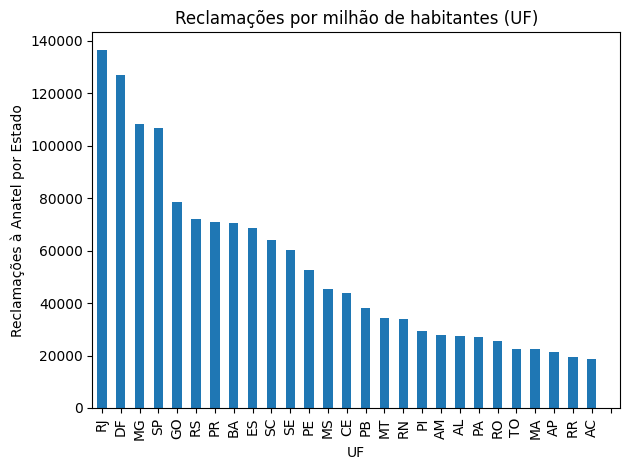

In [43]:
# Como já era esperado que o número de reclamações fosse proporcional à população, vamos normalizar em relação à população e procurar por quaisquer outliers. Utilizaremos a população de 2022 em https://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_popula%C3%A7%C3%A3o
populacao_estado = {
    "AC": 830_018,
    "AL": 3_127_683,
    "AM": 3_941_613,
    "AP": 733_759,
    "BA": 14_141_626,
    "CE": 8_794_957,
    "DF": 2_817_381,
    "ES": 3_833_712,
    "GO": 7_056_495,
    "MA": 6_776_699,
    "MG": 20_539_989,
    "MS": 2_757_013,
    "MT": 3_658_649,
    "PA": 8_120_131,
    "PB": 3_974_687,
    "PE": 9_058_931,
    "PI": 3_271_199,
    "PR": 11_444_380,
    "RJ": 16_055_174,
    "RN": 3_302_729,
    "RO": 1_581_196,
    "RR": 636_707,
    "RS": 10_882_965,
    "SC": 7_610_361,
    "SE": 2_210_004,
    "SP": 44_411_238,
    "TO": 1_511_460,
}
estados_counts = reclamacoes["UF"].value_counts().rename_axis("UF").reset_index(name="count").merge(
    pd.DataFrame(list(populacao_estado.items()), columns=["UF", "populacao"]), on="UF", how="left")

estados_counts["reclamacoes_por_milhao"] = estados_counts["count"] / estados_counts["populacao"] * 1000000

estados_counts.sort_values("reclamacoes_por_milhao", ascending=False).plot.bar(x="UF", y="reclamacoes_por_milhao", legend=False)
plt.ylabel("Reclamações à Anatel por Estado")
plt.title("Reclamações por milhão de habitantes (UF)")
plt.tight_layout()
plt.show()


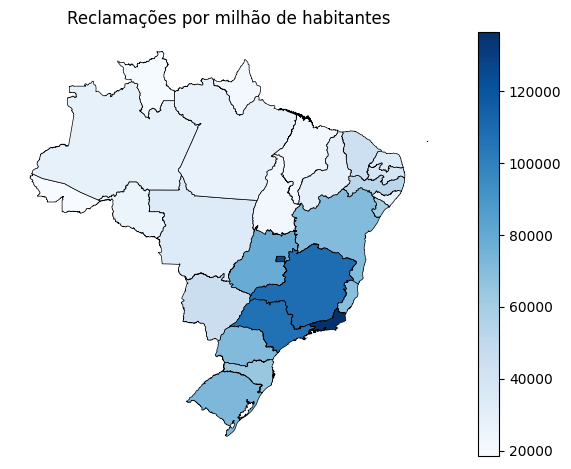

In [44]:
estados_gdf_normalizado = gpd.read_file("https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson")
estados_gdf_normalizado = estados_gdf_normalizado.rename(columns={"sigla": "UF"})
estados_gdf_normalizado = estados_gdf_normalizado.merge(estados_counts[["UF", "reclamacoes_por_milhao"]], on="UF", how="left")
estados_gdf_normalizado["reclamacoes_por_milhao"] = estados_gdf_normalizado["reclamacoes_por_milhao"]
ax = estados_gdf_normalizado.plot(column="reclamacoes_por_milhao", cmap="Blues", legend=True, edgecolor="black", linewidth=0.5)
ax.set_title("Reclamações por milhão de habitantes")
ax.axis("off")
plt.tight_layout()
plt.show()


In [45]:
# Surpreendentemente, o número de reclamações, normalizado pela população, varia significativamente entre estados. De grosso modo, os estados com maior taxa de reclamação à Anatel são os mais urbanos, e os com menor taxa de reclamação para a Anatel são os mais rurais. Diferenças na qualidade do serviço em cada local também explicam as discrepâncias.

In [ ]:
# Agora que extraímos um conhecimento espacial, vamos tentar extrair um conhecimento temporal das marcas. Primeiramente, o índice do dataset deve ser a data em AnoMês:
reclamacoes.set_index("AnoMês", inplace=True)

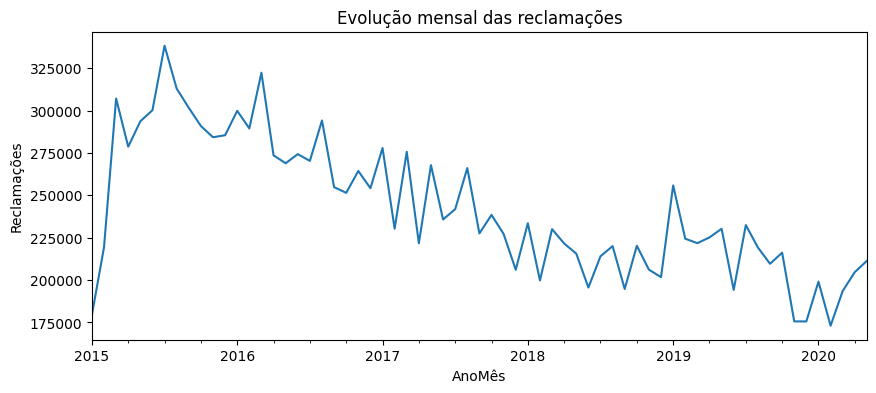

In [49]:
# A menor resolução temporal em AnoMês é mensal. Vamos fazer uma análise temporal
monthly_counts = reclamacoes.resample("ME").size()
plt.figure(figsize=(10, 4))
monthly_counts.plot(color="tab:blue")
plt.ylabel("Reclamações")
plt.title("Evolução mensal das reclamações")
plt.show()


In [50]:
# Podemos notar uma tendência de declínio nas reclamações feitas à Anatel. Isso pode ser causado tanto por uma melhoria do serviço, quanto por um declínio na popularidade do portal de reclamações da Anatel.
# Agora, vamos fazer uma análise sazonal:

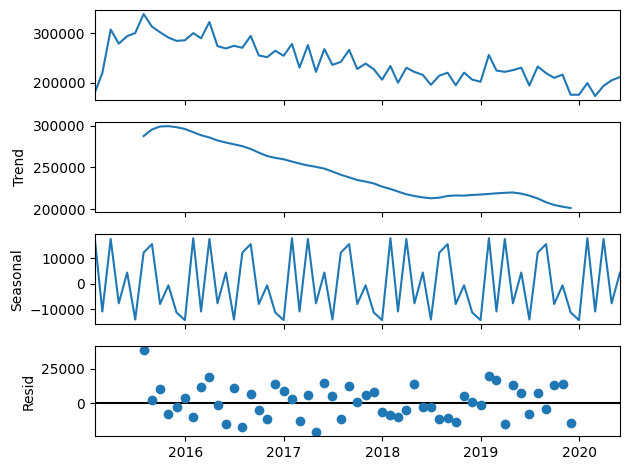

In [57]:
decomposicao = seasonal_decompose(monthly_counts.asfreq("ME"), model="additive", period=12)
fig = decomposicao.plot()
plt.show()

In [58]:
# Devido aos altos resíduos, não notamos tendências sazonais significativas nas reclamações à Anatel. A partir disso, pode-se concluir que a qualidade do serviço não depende significativamente do mês do ano.

In [ ]:
# Vamos observar a evolução temporal das reclamações das 6 principais marcas:

C:\Users\Tomaz\AppData\Local\Temp\ipykernel_8604\3186757430.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([pd.Grouper(freq="ME"), "Marca"])


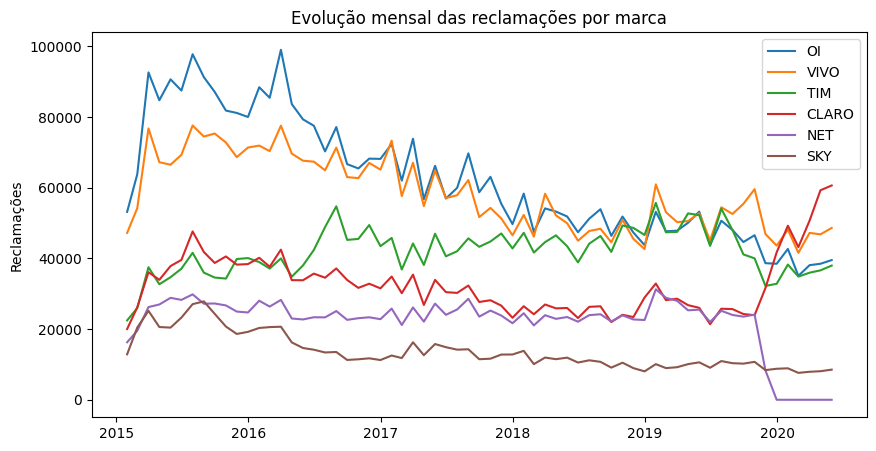

In [65]:
top_brands = reclamacoes["Marca"].value_counts().head(6).index.tolist()
marcas_mensal = (
    reclamacoes[reclamacoes["Marca"].isin(top_brands)]
    .groupby([pd.Grouper(freq="ME"), "Marca"])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(10, 5))
for marca in top_brands:
    if marca in marcas_mensal.columns:
        plt.plot(marcas_mensal.index, marcas_mensal[marca], label=marca)
plt.ylabel("Reclamações")
plt.title("Evolução mensal das reclamações por marca")
plt.legend()
plt.show()

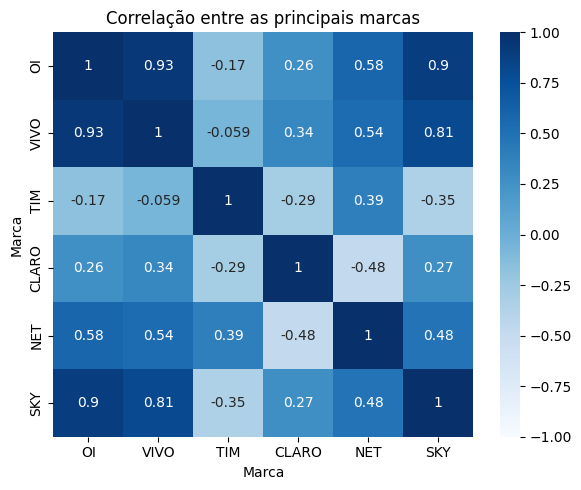

In [70]:
corr_marcas = marcas_mensal[top_brands].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_marcas, annot=True, cmap="Blues", vmin=-1, vmax=1)
plt.title("Correlação entre as principais marcas")
plt.tight_layout()
plt.show()

In [69]:
# Notamos altas correlações entre certas marcas. Por exemplo, OI e VIVO, e OI e SKY. Isso pode ser explicado pela maior infraestrutura compartilhada entre essas empresas.